![IP Paris](img/ipp.png)

# RAMP starting kit on Energy Consumption (EC) and Greenhouse gases (GHG) classification

_Authors: Cyril Zaimi, Guillaume Philippe, Matteo Ratet, Max Wu, Pierre Loviton, & Hugo Peltier_

This challenge was done as a project for the Master 2 Data Science (2022/2023), DATACAMP course

## Introduction

One of the main levers of the ecological transition is to act on emissions from buildings. Indeed, according to the International Energy Agency, they account for approximately 28% of national greenhouse gas emissions. This is why this sector is at the heart of a massive investment plan launched in 2021 by the government. France has set itself the goal of reducing the energy consumption of existing buildings by 38% by 2030. 

The **Energy Performance Diagnostic** (EPD) is a tool that has been introduced to evaluate the energy efficiency of buildings. Its primary purpose is to help identify areas where a structure is wasting energy and suggest ways to improve energy performance. This can involve recommendations on how to upgrade insulation, replace inefficient heating or cooling systems, install energy-efficient lighting, and more.

According to recent estimates, of the 30 million primary residences in metropolitan France, as of January 1st, 2022, approximately 5.2 million homes would be an energy leak (labels F and G). This project aims at constructing a model capable of estimating the **energy consumption** (EC) and **greenhouse gas emissions** (GGE) to locate more precisely the renovations to be undertaken in priority.

#### Useful links

- [Features description](https://koumoul.com/data-fair/embed/dataset/dpe-tertiaire/fields)

![](img/performance.png)

## Getting started with the RAMP starting kit

### Software prerequisites

This starting kit requires the following dependencies:

* `numpy`
* `pandas`
* `geopandas`
* `scikit-learn`
* `jupyter`
* `seaborn`
* `matplotlib`
* `tqdm`
* `gzip`
* `os`
* `shutil`
* `urllib`
* `json`
* `rampwf`
* `folium`

The requirements can be installed by running:

    pip install -r requirements.txt

In [1]:
import folium

import numpy as np
import pandas as pd
import geopandas as gpd

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

from problem import *

# set color palette to seaborn

# Download data and format it

### Getting the data

The public train and test data can be downloaded by running from the root of the starting kit:

```shell
python download_data.py
```


In [2]:
X_train, Y_train = get_train_data()
X_test, Y_test = get_test_data()

In [3]:
X_train.head()

,tr002_type_batiment_id,secteur_activite,tr012_categorie_erp_id,tr013_type_erp_id,annee_construction,surface_habitable,surface_thermique_lot,tv016_departement_id,commune,arrondissement,...,tv017_zone_hiver_code,tv017_zone_hiver_t_ext_moyen,tv017_zone_hiver_peta_cw,tv017_zone_hiver_dh14,tv017_zone_hiver_prs1,tv018_zone_ete_code,tv018_zone_ete_sclim_inf_150,tv018_zone_ete_sclim_sup_150,tv018_zone_ete_rclim_autres_etages,tv018_zone_ete_rclim_dernier_etage
id,,,,,,,,,,,,,,,,,,,,,
10408629,4,\N,5,\N,1947,110.00,110.00,62,AIRE SUR LA LYS,None,...,H1,6.58,10.5,42030,3.6,Ea,2,4,1.5,2
48420,4,tabac presse,\N,\N,1974,164.24,164.24,59,CAPPELLE-LA-GRANDE,00,...,H1,6.58,10.5,42030,3.6,Ea,2,4,1.5,2
7710054,4,"Bureau, Administration, Enseignement",\N,\N,1947,164.56,164.56,75,PARIS 03,None,...,H1,6.58,10.5,42030,3.6,Eb,3,5,2.0,3
11399812,4,None,\N,\N,1970,0.00,0.00,60,BEAUVAIS,00,...,H1,6.58,10.5,42030,3.6,Ea,2,4,1.5,2
7837691,4,None,\N,12,1980,0.00,0.00,43,BRIVES-CHARENSAC,00,...,H1,6.58,10.5,42030,3.6,Ec,4,6,3.0,4


In [4]:
Y_train.head()

,classe_consommation_energie,classe_estimation_ges
id,,
10408629,D,C
48420,D,D
7710054,C,D
11399812,D,B
7837691,D,D


In [5]:
X_train.shape, X_test.shape

((130937, 103), (56116, 103))

In [6]:
Y_train.shape, Y_test.shape

((130937, 2), (56116, 2))

# Descriptive statistics

In [7]:
df_train = pd.concat([X_train, Y_train], axis=1)
df_test = pd.concat([X_test, Y_test], axis=1)

df = pd.concat([df_train, df_test], axis=0)

In [8]:
df_train.shape

(130937, 105)

In [9]:
df.describe()

,tr002_type_batiment_id,annee_construction,tv016_departement_id,etat_avancement,est_efface,longitude,latitude,geo_score,tr002_type_batiment_est_efface,tr002_type_batiment_ordre,...,tv016_departement_fecs_ancienne_i_c,tv016_departement_fecs_recente_i_c,tv017_zone_hiver_t_ext_moyen,tv017_zone_hiver_peta_cw,tv017_zone_hiver_dh14,tv017_zone_hiver_prs1,tv018_zone_ete_sclim_inf_150,tv018_zone_ete_sclim_sup_150,tv018_zone_ete_rclim_autres_etages,tv018_zone_ete_rclim_dernier_etage
count,187053.000000,187053.000000,187053.000000,187053.0,187053.0,187053.000000,187053.000000,187053.000000,187053.0,187053.000000,...,187053.000000,187053.000000,187053.000000,187053.000000,187053.000000,187053.000000,187053.000000,187053.000000,187053.000000,187053.000000
mean,4.025164,1965.262225,55.993665,1.0,0.0,2.718157,47.214891,0.815826,0.0,4.974836,...,29.717075,42.759956,7.258081,11.260554,37909.521419,3.483813,3.319220,5.319220,2.406716,3.319220
std,0.156623,77.670844,25.487928,0.0,0.0,2.742295,2.093733,0.210064,0.0,0.156623,...,4.790128,8.696925,0.992353,1.203829,6205.918603,0.201932,0.885804,0.885804,0.768040,0.885804
min,4.000000,-1.000000,1.000000,1.0,0.0,-61.525777,16.415924,0.300000,0.0,4.000000,...,24.000000,0.000000,6.580000,10.500000,22200.000000,2.900000,2.000000,4.000000,1.500000,2.000000
25%,4.000000,1947.000000,35.000000,1.0,0.0,1.149685,45.744920,0.690000,0.0,5.000000,...,26.000000,38.000000,6.580000,10.500000,33300.000000,3.400000,3.000000,5.000000,2.000000,3.000000
50%,4.000000,1969.000000,62.000000,1.0,0.0,2.408653,47.769940,0.950000,0.0,5.000000,...,28.000000,41.000000,6.580000,10.500000,42030.000000,3.600000,3.000000,5.000000,2.000000,3.000000
75%,4.000000,1989.000000,75.000000,1.0,0.0,4.861759,48.865288,0.970000,0.0,5.000000,...,32.000000,46.000000,8.080000,12.000000,42030.000000,3.600000,4.000000,6.000000,3.000000,4.000000
max,5.000000,20011.000000,97.000000,1.0,0.0,9.551810,51.080627,0.990000,0.0,5.000000,...,43.000000,62.000000,9.650000,14.500000,42030.000000,3.600000,5.000000,7.000000,4.000000,5.000000


In [10]:
# keep column with int type
df_float = df.select_dtypes(include=["int", "float"])
df_float.shape

(187053, 40)

In [11]:
df_float.columns

Index(['tr002_type_batiment_id', 'annee_construction', 'tv016_departement_id',
       'etat_avancement', 'est_efface', 'longitude', 'latitude', 'geo_score',
       'tr002_type_batiment_est_efface', 'tr002_type_batiment_ordre',
       'tr002_type_batiment_simulateur', 'tr012_categorie_erp_est_efface',
       'tr013_type_erp_categorie_id', 'tr013_type_erp_est_efface',
       'tv017_zone_hiver_id', 'tv018_zone_ete_id', 'tv016_departement_altmin',
       'tv016_departement_altmax', 'tv016_departement_nref',
       'tv016_departement_dhref', 'tv016_departement_pref',
       'tv016_departement_c2', 'tv016_departement_c3', 'tv016_departement_c4',
       'tv016_departement_t_ext_basse', 'tv016_departement_e',
       'tv016_departement_fch', 'tv016_departement_fecs_ancienne_m_i',
       'tv016_departement_fecs_recente_m_i',
       'tv016_departement_fecs_solaire_m_i',
       'tv016_departement_fecs_ancienne_i_c',
       'tv016_departement_fecs_recente_i_c', 'tv017_zone_hiver_t_ext_moyen',
     

# Features description

- annee_construction : year of construction of the building
- surface_habitable : the surface which is habitable in $m^2$     
- surface_thermique_lot : measures the quantity of heat necessary to maintain a given temperature on the building 
- surface_commerciale_contractuelle : the sales area in $m^2$ that is leased or made available by the owner of a commercial property to a tenant     
- shon : measures the surface in $m^2$ of all the closed and covered premises of a building, intended to be occupied (residential premises, offices, shops, etc.)
- surface_utile : measure in $m^2$ calculated by deducting from the living area the parts of the area that cannot be used for human occupation, such as walls, partitions, posts, stairwells, service shafts, lost attic space, etc. In other words, the useful surface measures the actual surface available for the occupant's activities.
- surface_thermique_parties_communes : the surface area in $m^2$ of the common parts of a building, such as lobbies, staircases, corridors, cellars and parking lots, which have an impact on the building's energy consumption
- nombre_niveaux : number of floors
- surface_verriere : the surface in $m^2$ of the glazed elements of a construction, such as windows, French windows, bay windows, glass roofs, glazing of verandas, etc.                     
- nombre_entrees_avec_sas : the number of entrances of a building that are equipped with an airlock. An airlock is an enclosed space between the exterior and interior of a building, which limits heat loss and air infiltration
- nombre_entrees_sans_sas : the number of entrances of a building that are **NOT** equipped with an airlock. An airlock is an enclosed space between the exterior and interior of a building, which limits heat loss and air infiltration
- surface_baies_orientees_nord : area of glazed elements in a building, such as windows, patio doors, bay windows, skylights, conservatory glazing, etc., that face **NORTH** in $m^2$
- surface_baies_orientees_est_ouest : area of glazed elements in a building, such as windows, patio doors, bay windows, skylights, conservatory glazing, etc., that face **EAST or WEST** in $m^2$
- surface_baies_orientees_sud : area of glazed elements in a building, such as windows, patio doors, bay windows, skylights, conservatory glazing, etc., that face **SOUTH** in $m^2$
- surface_planchers_hauts_deperditifs : the surface of floors in $m^2$ separating heated premises from unheated premises, such as lost attics, basements, garages or courtyards, which are considered as thermal buffer zones.
- surface_planchers_bas_deperditifs :  the surface area of floors separating heated premises from the ground or crawl space, which are considered as thermal buffer zones.
- surface_parois_verticales_opaques_deperditives : the surface of exterior or interior walls of a building that are in direct contact with the outside air or unheated premises, such as cellars, garages or basements in $m^2$
- longitude : longitude
- latitude : latitude


# NaN in data

<Axes: ylabel='id'>

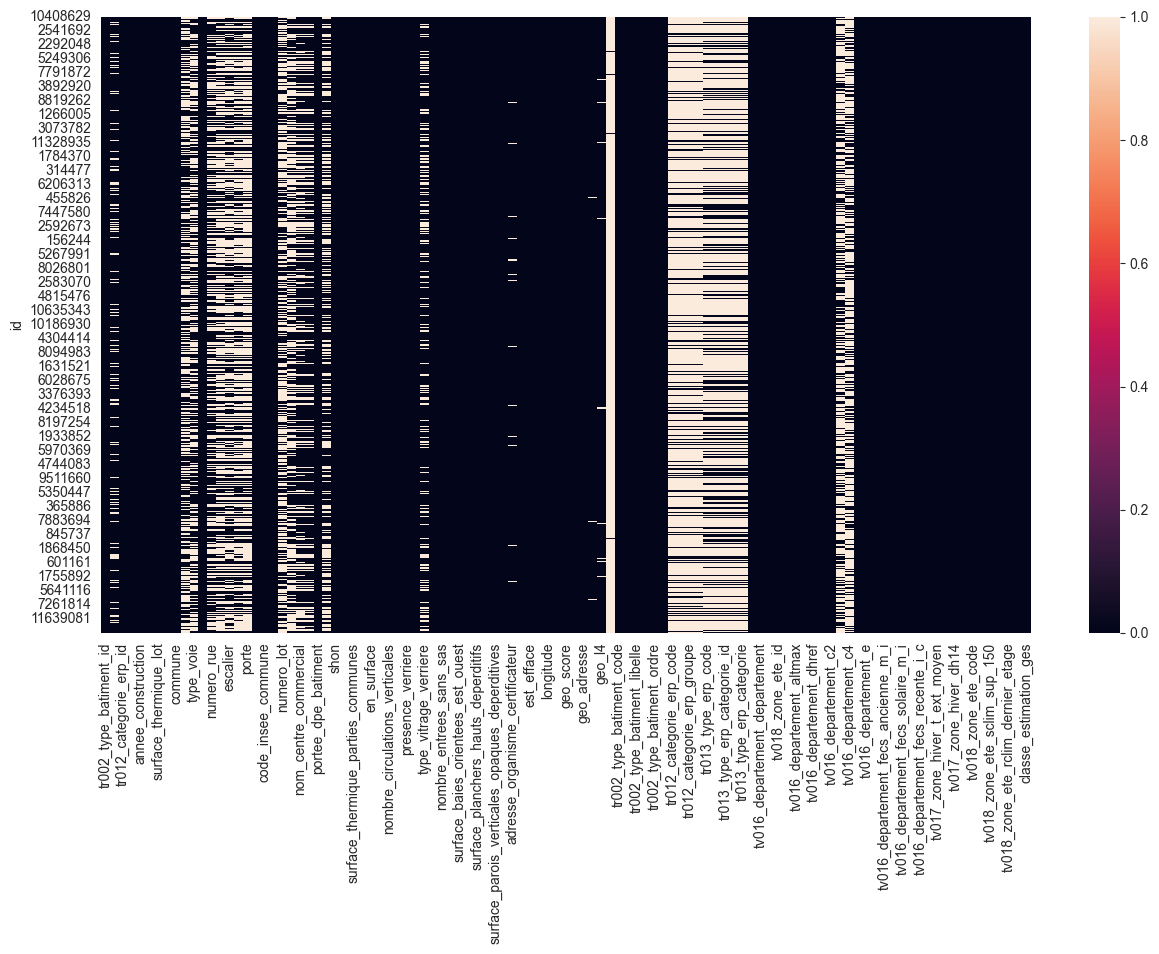

In [12]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.isna())

# Interactive map

In [13]:
dpe = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs=4326
)
dpe = dpe.dropna(subset=["longitude", "latitude"])

In [14]:
palette = sns.color_palette("coolwarm", 8)


def interactive_map_dpe(dpe):
    # convert in number
    dpe["color"] = [
        ord(dpe.iloc[i]["classe_consommation_energie"].lower()) - 96
        for i in range(len(dpe))
    ]
    dpe = dpe.loc[dpe["color"] <= 7]
    dpe["color"] = [palette.as_hex()[x] for x in dpe["color"]]

    center = dpe[["latitude", "longitude"]].mean().values.tolist()
    sw = dpe[["latitude", "longitude"]].min().values.tolist()
    ne = dpe[["latitude", "longitude"]].max().values.tolist()

    m = folium.Map(location=center, tiles="Stamen Toner")

    # I can add marker one by one on the map
    for i in range(0, len(dpe)):
        folium.Marker(
            [dpe.iloc[i]["latitude"], dpe.iloc[i]["longitude"]],
            popup=f"Année de construction: {dpe.iloc[i]['annee_construction']}, <br>DPE: {dpe.iloc[i]['classe_consommation_energie']}",
            icon=folium.Icon(
                color="black", icon="home", icon_color=dpe.iloc[i]["color"]
            ),
        ).add_to(m)

    m.fit_bounds([sw, ne])

    return m


m = interactive_map_dpe(dpe.head(10))

/Users/guillaumephilippe/own-ramp-kit/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [15]:
m

# Labels exploration

In [16]:
Y_train.iloc[:, 0].value_counts()

D    31146
C    27741
E    21846
G    17378
F    12271
B    10449
A    10106
Name: classe_consommation_energie, dtype: int64

In [17]:
Y_train.iloc[:, 1].value_counts()

B    36190
C    34519
A    23413
D    21781
E     9368
F     3176
G     2490
Name: classe_estimation_ges, dtype: int64

In [18]:
Y = pd.concat([Y_train, Y_test], axis=0)
Y.shape

(187053, 2)

In [19]:
energy_consumption_classes = pd.Categorical(Y["classe_consommation_energie"])
green_house_classes = pd.Categorical(Y["classe_estimation_ges"])

Y_categorical = Y.copy()
Y_categorical["classe_consommation_energie"] = energy_consumption_classes
Y_categorical["classe_estimation_ges"] = green_house_classes

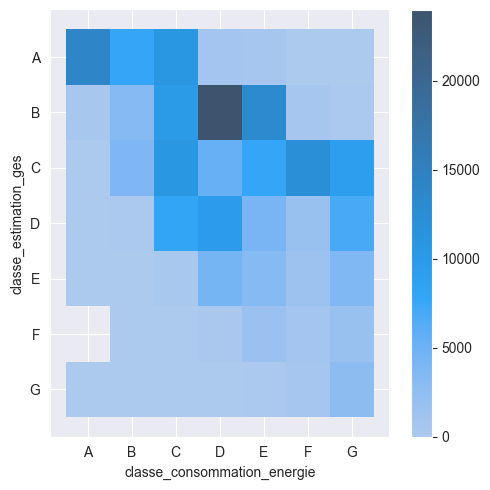

In [20]:
sns.displot(
    Y_categorical,
    x="classe_consommation_energie",
    y="classe_estimation_ges",
    cbar=True,
)
plt.show()

# Preprocessing

- Drop useless columns
- Fill NaN values (mean impute, etc.)

In [21]:
# Remove useless columns
X_filtered = X_train.drop(
    columns=[
        "commune",
        "arrondissement",
        "type_voie",
        "nom_rue",
        "numero_rue",
        "code_postal",
        "code_insee_commune",
        "code_insee_commune_actualise",
        "numero_lot",
        "nom_centre_commercial",
        "tr002_type_batiment_id",
        "secteur_activite",
        "tr012_categorie_erp_id",
        "tr013_type_erp_id",
        "tv016_departement_id",
        "batiment",
        "escalier",
        "etage",
        "porte",
        "quote_part",
        "portee_dpe_batiment",
        "partie_batiment",
        "en_souterrain",
        "en_surface",
        "nombre_circulations_verticales",  # faible variance
        "nombre_boutiques",  # faible variance"
        "presence_verriere",
        "type_vitrage_verriere",  # faible variance
        "etat_avancement",
        "adresse_organisme_certificateur",
        "dpe_vierge",  # faible variance
        "est_efface",  # faible variance
        "date_reception_dpe",  # date
        "geo_score",
        "geo_type",
        "geo_adresse",
        "geo_id",
        "geo_l4",
        "geo_l5",
        "tr002_type_batiment_code",
        "tr002_type_batiment_description",
        "tr002_type_batiment_libelle",
        "tr002_type_batiment_est_efface",
        "tr002_type_batiment_ordre",
        "tr002_type_batiment_simulateur",
        "tr012_categorie_erp_code",
        "tr012_categorie_erp_categorie",
        "tr012_categorie_erp_groupe",
        "tr012_categorie_erp_est_efface",
        "tr013_type_erp_code",
        "tr013_type_erp_type",
        "tr013_type_erp_categorie_id",
        "tr013_type_erp_est_efface",
        "tr013_type_erp_categorie",
        "tv016_departement_code",
        "tv016_departement_departement",
        "tv017_zone_hiver_id",
        "tv018_zone_ete_id",
        "tv016_departement_altmin",
        "tv016_departement_altmax",
        "tv016_departement_nref",
        "tv016_departement_dhref",
        "tv016_departement_pref",
        "tv016_departement_c2",
        "tv016_departement_c3",
        "tv016_departement_c4",
        "tv016_departement_t_ext_basse",
        "tv016_departement_e",
        "tv016_departement_fch",
        "tv016_departement_fecs_ancienne_m_i",
        "tv016_departement_fecs_recente_m_i",
        "tv016_departement_fecs_solaire_m_i",
        "tv016_departement_fecs_ancienne_i_c",
        "tv016_departement_fecs_recente_i_c",
        "tv017_zone_hiver_code",
        "tv017_zone_hiver_t_ext_moyen",
        "tv017_zone_hiver_peta_cw",
        "tv017_zone_hiver_dh14",
        "tv017_zone_hiver_prs1",
        "tv018_zone_ete_code",
        "tv018_zone_ete_sclim_inf_150",
        "tv018_zone_ete_sclim_sup_150",
        "tv018_zone_ete_rclim_autres_etages",
        "tv018_zone_ete_rclim_dernier_etage",
    ]
)

# list of columns to convert to float which is replacing a "\N" to "0.00" among possible values
nan_to_clean = [
    "surface_parois_verticales_opaques_deperditives",
    "surface_planchers_bas_deperditifs",
    "surface_planchers_hauts_deperditifs",
    "surface_baies_orientees_sud",
    "surface_baies_orientees_est_ouest",
    "surface_baies_orientees_nord",
    "nombre_entrees_sans_sas",
    "nombre_entrees_avec_sas",
    "surface_verriere",
    "nombre_niveaux",
    "surface_utile",
    "shon",
    "surface_commerciale_contractuelle",
    "surface_thermique_lot",
    "surface_habitable",
    "surface_thermique_parties_communes",
]
for col in nan_to_clean:
    X_filtered[col] = X_filtered[col].replace(r"\N", "0.00")
    X_filtered[col] = X_filtered[col].replace(",", "")  # clean the decimals
    X_filtered[col] = pd.to_numeric(X_filtered[col], errors="coerce")

# Replace NaN by mean for 'surface_commerciale_contractuelle'
X_filtered["surface_commerciale_contractuelle"] = X_filtered[
    "surface_commerciale_contractuelle"
].fillna(X_filtered["surface_commerciale_contractuelle"].mean())

X_filtered.shape

(130937, 19)

In [22]:
X_filtered.head()

,annee_construction,surface_habitable,surface_thermique_lot,surface_commerciale_contractuelle,shon,surface_utile,surface_thermique_parties_communes,nombre_niveaux,surface_verriere,nombre_entrees_avec_sas,nombre_entrees_sans_sas,surface_baies_orientees_nord,surface_baies_orientees_est_ouest,surface_baies_orientees_sud,surface_planchers_hauts_deperditifs,surface_planchers_bas_deperditifs,surface_parois_verticales_opaques_deperditives,longitude,latitude
id,,,,,,,,,,,,,,,,,,,
10408629,1947,110.00,110.00,0.000000,0.0,100.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.391482,50.638385
48420,1974,164.24,164.24,5.978682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.382002,51.000695
7710054,1947,164.56,164.56,0.000000,149.6,100.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.360872,48.857859
11399812,1970,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.065088,49.429748
7837691,1980,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.908481,45.052505


In [23]:
X_filtered.dtypes

annee_construction                                  int64
surface_habitable                                 float64
surface_thermique_lot                             float64
surface_commerciale_contractuelle                 float64
shon                                              float64
surface_utile                                     float64
surface_thermique_parties_communes                float64
nombre_niveaux                                    float64
surface_verriere                                  float64
nombre_entrees_avec_sas                           float64
nombre_entrees_sans_sas                           float64
surface_baies_orientees_nord                      float64
surface_baies_orientees_est_ouest                 float64
surface_baies_orientees_sud                       float64
surface_planchers_hauts_deperditifs               float64
surface_planchers_bas_deperditifs                 float64
surface_parois_verticales_opaques_deperditives    float64
longitude     

## Energy consumption

A significant temporal evolution of the housing market and energy consumption

In [24]:
df_filtered = X_filtered.join(Y, how="left")[
    ["annee_construction", "classe_consommation_energie"]
]
df_filtered["decade"] = np.floor(df_filtered["annee_construction"] / 10) * 10
df_filtered["decade"] = df_filtered["decade"].astype(int)
df_filtered = df_filtered[
    (df_filtered["decade"] >= 1940) & (df_filtered["decade"] < 2020)
]
df_filtered = df_filtered.groupby(["decade", "classe_consommation_energie"]).count()
df_filtered["decade_class"] = df_filtered.index.to_numpy()
loc = pd.DataFrame.from_records(
    df_filtered.decade_class.reset_index(drop=True),
    columns=["decade", "classe"],
    index=df_filtered.index,
)

df_filtered["Number of buildings"] = df_filtered["annee_construction"]
df_filtered = df_filtered.join(loc, how="left")[["Number of buildings"]].reset_index()

df_filtered = df_filtered.pivot(
    values="Number of buildings",
    index="decade",
    columns="classe_consommation_energie",
)

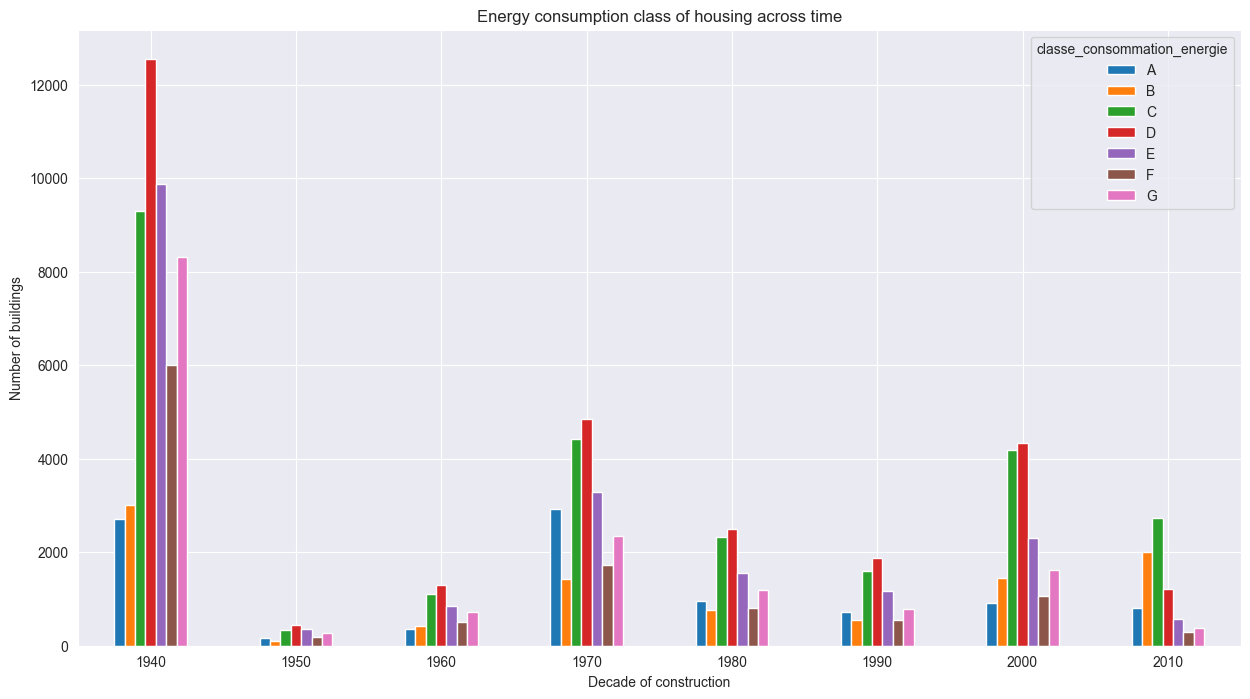

In [25]:
df_filtered.plot(
    kind="bar",
    stacked=False,
    xlabel="Decade of construction",
    ylabel="Number of buildings",
    figsize=(15, 8),
    rot=0,
    title="Energy consumption class of housing across time",
)
plt.show()

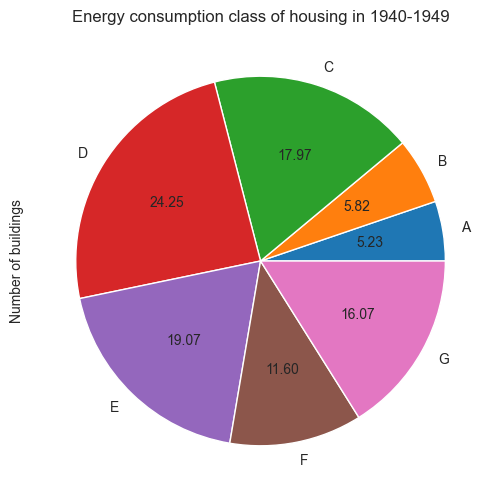

In [26]:
df_filtered.loc[1940, :].plot(
    kind="pie",
    xlabel=1940,
    ylabel="Number of buildings",
    figsize=(6, 6),
    autopct="%.2f",
    title="Energy consumption class of housing in 1940-1949",
)
plt.show()

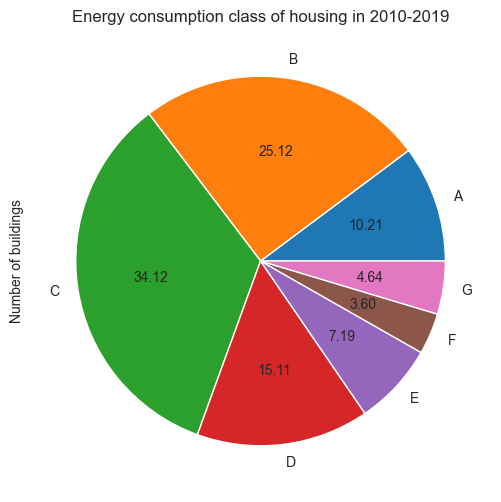

In [27]:
df_filtered.loc[2010, :].plot(
    kind="pie",
    xlabel=2020,
    ylabel="Number of buildings",
    figsize=(6, 6),
    autopct="%.2f",
    title="Energy consumption class of housing in 2010-2019",
)
plt.show()

## Greenhouse gaz emission

In [28]:
df_filtered = X_filtered.join(Y, how="left")[
    ["annee_construction", "classe_estimation_ges"]
]
df_filtered["decade"] = np.floor(df_filtered["annee_construction"] / 10) * 10
df_filtered["decade"] = df_filtered["decade"].astype(int)
df_filtered = df_filtered[
    (df_filtered["decade"] >= 1940) & (df_filtered["decade"] < 2020)
]
df_filtered = df_filtered.groupby(["decade", "classe_estimation_ges"]).count()
df_filtered["decade_class"] = df_filtered.index.to_numpy()
loc = pd.DataFrame.from_records(
    df_filtered.decade_class.reset_index(drop=True),
    columns=["decade", "classe"],
    index=df_filtered.index,
)

df_filtered["Number of buildings"] = df_filtered["annee_construction"]
df_filtered = df_filtered.join(loc, how="left")[["Number of buildings"]].reset_index()

df_filtered = df_filtered.pivot(
    values="Number of buildings", index="decade", columns="classe_estimation_ges"
)

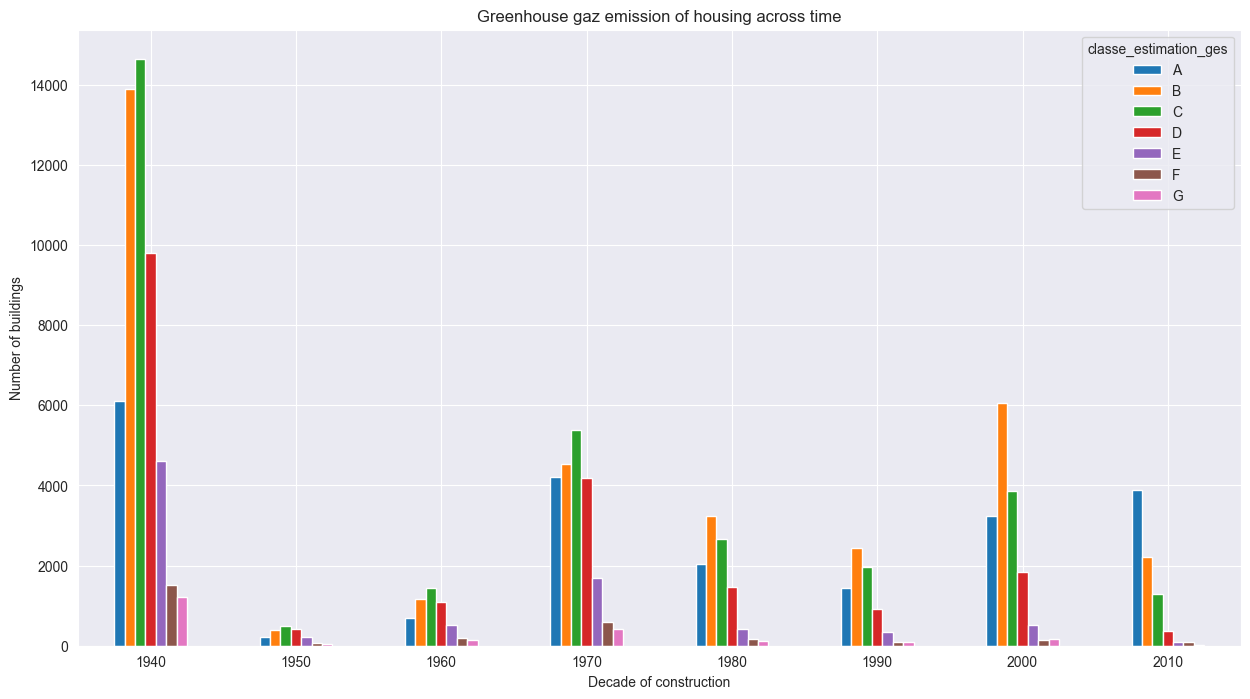

In [29]:
df_filtered.plot(
    kind="bar",
    stacked=False,
    xlabel="Decade of construction",
    ylabel="Number of buildings",
    figsize=(15, 8),
    rot=0,
    title="Greenhouse gaz emission of housing across time",
)
plt.show()

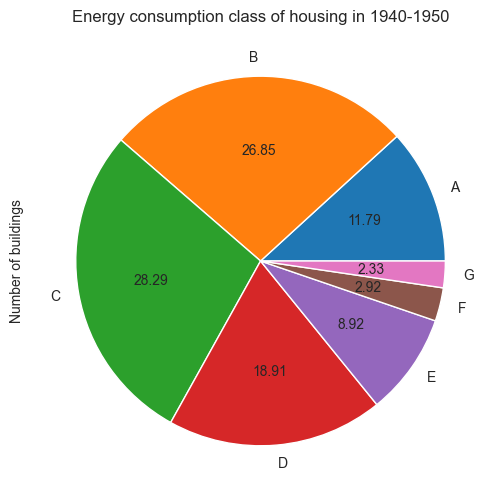

In [30]:
df_filtered.loc[1940, :].plot(
    kind="pie",
    xlabel=1940,
    ylabel="Number of buildings",
    figsize=(6, 6),
    autopct="%.2f",
    title="Energy consumption class of housing in 1940-1950",
)
plt.show()

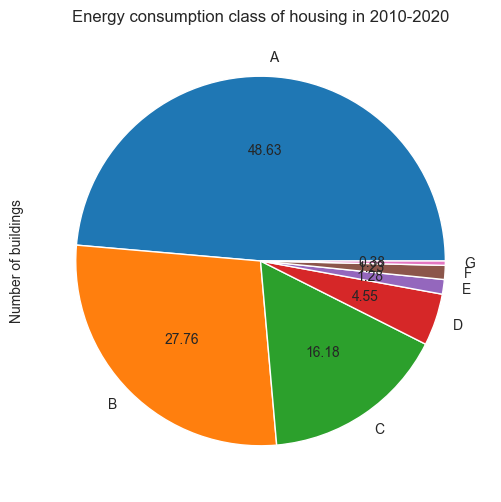

In [31]:
df_filtered.loc[2010, :].plot(
    kind="pie",
    xlabel=2020,
    ylabel="Number of buildings",
    figsize=(6, 6),
    autopct="%.2f",
    title="Energy consumption class of housing in 2010-2020",
)
plt.show()

## Difference in activities and environmental impact

In [32]:
df_classement = (
    X_train.groupby(by="secteur_activite")["tr002_type_batiment_id"]
    .count()
    .sort_values(ascending=False)
)
df_classement.head(20)

secteur_activite
\N                                               30368
Autres (théâtres, salles de sport, restaurati    22110
Commerce                                         11765
Bureau, Administration, Enseignement              8778
Bureaux                                           7346
bureaux                                           5449
Autres                                            3484
Habitation (Parties privatives d'immeuble col     1950
enseignement                                      1796
Centres Commerciaux                               1417
Industrie                                         1114
Occupation continue (hôpitaux, hôtels, intern      955
Artisanat                                          767
Local commercial                                   679
Magasin de vente                                   647
commerce                                           523
Restaurant                                         472
autres bâtiments                                

In [33]:
liste_familles_principales = [
    "Commerce",
    "Bureaux",
    "Bureau, Administration, Enseignement",
    "Autres (théâtres, salles de sport, restaurati",
]
X_train_secteur = X_train[X_train["secteur_activite"].isin(liste_familles_principales)]
df_filtered_2 = X_train_secteur.join(Y, how="left")[
    ["secteur_activite", "classe_estimation_ges", "annee_construction"]
]
df_filtered_3 = df_filtered_2.groupby(
    ["secteur_activite", "classe_estimation_ges"]
).count()

df_filtered_3.rename(columns={"annee_construction": "nombre"}, inplace=True)
df_filtered_3["secteur_classe"] = df_filtered_3.index.to_numpy()
df_filtered_3
loc = pd.DataFrame.from_records(
    df_filtered_3.secteur_classe.reset_index(drop=True),
    columns=["secteur_activite", "classe_estimation_ges"],
    index=df_filtered_3.index,
)


df_filtered_3 = df_filtered_3.join(loc, how="left")[["nombre"]].reset_index()

df_filtered_3 = df_filtered_3.pivot(
    values="nombre", index="secteur_activite", columns="classe_estimation_ges"
)

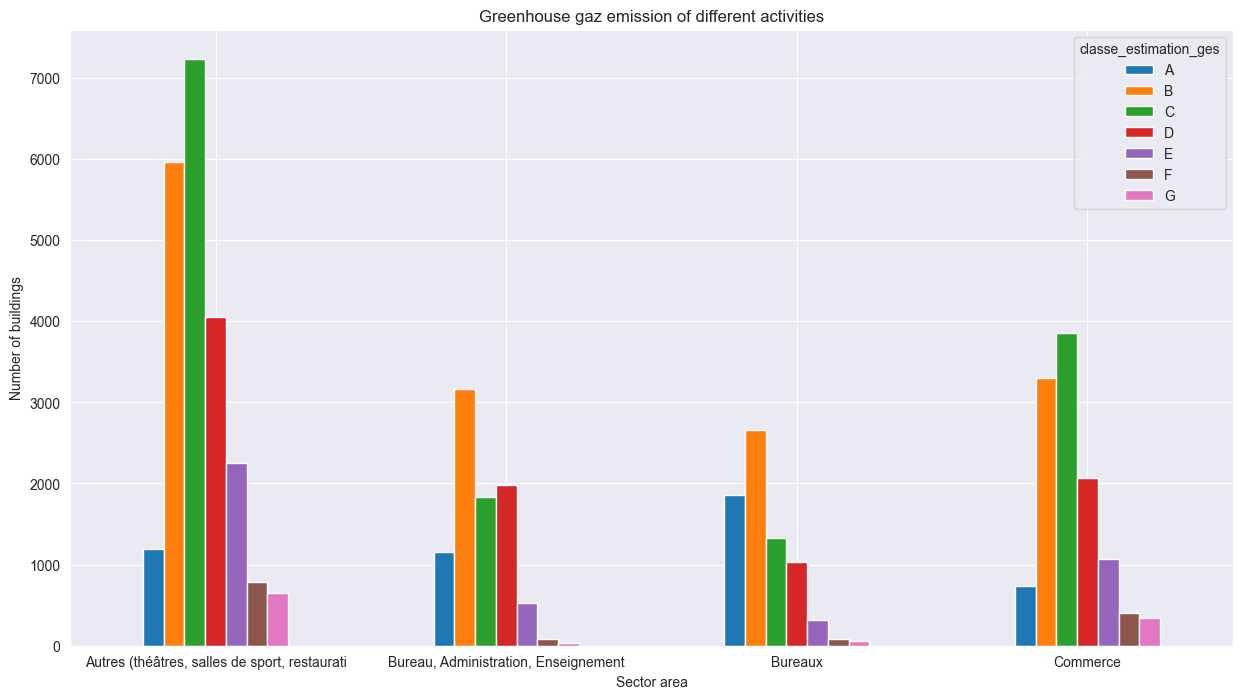

In [34]:
df_filtered_3.plot(
    kind="bar",
    stacked=False,
    xlabel="Sector area",
    ylabel="Number of buildings",
    figsize=(15, 8),
    rot=0,
    title="Greenhouse gaz emission of different activities",
)
plt.show()

## The model to submit

The submission consists of one file: `estimator.py` which defines a `Preprocessor` class, and a `Classifier` class, these two class are combined in a function `get_estimator` used for prediction

- `Preprocessor` can (optionally) hold code to calculate and add additional features.
- `Classifier` fits the model and predicts on (new) data, as outputted by the `Preprocessor`. The prediction should be in the form of a (n_samples, 2) array with the probabilities of the two classes.

In [35]:
class Preprocessor(BaseEstimator):
    def fit(self, X, y):
        return self

    def transform(self, X):
        # Remove useless columns
        X = X.drop(
            columns=[
                "commune",
                "arrondissement",
                "type_voie",
                "nom_rue",
                "numero_rue",
                "code_postal",
                "code_insee_commune",
                "code_insee_commune_actualise",
                "numero_lot",
                "nom_centre_commercial",
                "tr002_type_batiment_id",
                "secteur_activite",
                "tr012_categorie_erp_id",
                "tr013_type_erp_id",
                "tv016_departement_id",
                "batiment",
                "escalier",
                "etage",
                "porte",
                "quote_part",
                "portee_dpe_batiment",
                "partie_batiment",
                "en_souterrain",
                "en_surface",
                "nombre_circulations_verticales",  # faible variance
                "nombre_boutiques",  # faible variance"
                "presence_verriere",
                "type_vitrage_verriere",  # faible variance
                "etat_avancement",
                "adresse_organisme_certificateur",
                "dpe_vierge",  # faible variance
                "est_efface",  # faible variance
                "date_reception_dpe",  # date
                "geo_score",
                "geo_type",
                "geo_adresse",
                "geo_id",
                "geo_l4",
                "geo_l5",
                "tr002_type_batiment_code",
                "tr002_type_batiment_description",
                "tr002_type_batiment_libelle",
                "tr002_type_batiment_est_efface",
                "tr002_type_batiment_ordre",
                "tr002_type_batiment_simulateur",
                "tr012_categorie_erp_code",
                "tr012_categorie_erp_categorie",
                "tr012_categorie_erp_groupe",
                "tr012_categorie_erp_est_efface",
                "tr013_type_erp_code",
                "tr013_type_erp_type",
                "tr013_type_erp_categorie_id",
                "tr013_type_erp_est_efface",
                "tr013_type_erp_categorie",
                "tv016_departement_code",
                "tv016_departement_departement",
                "tv017_zone_hiver_id",
                "tv018_zone_ete_id",
                "tv016_departement_altmin",
                "tv016_departement_altmax",
                "tv016_departement_nref",
                "tv016_departement_dhref",
                "tv016_departement_pref",
                "tv016_departement_c2",
                "tv016_departement_c3",
                "tv016_departement_c4",
                "tv016_departement_t_ext_basse",
                "tv016_departement_e",
                "tv016_departement_fch",
                "tv016_departement_fecs_ancienne_m_i",
                "tv016_departement_fecs_recente_m_i",
                "tv016_departement_fecs_solaire_m_i",
                "tv016_departement_fecs_ancienne_i_c",
                "tv016_departement_fecs_recente_i_c",
                "tv017_zone_hiver_code",
                "tv017_zone_hiver_t_ext_moyen",
                "tv017_zone_hiver_peta_cw",
                "tv017_zone_hiver_dh14",
                "tv017_zone_hiver_prs1",
                "tv018_zone_ete_code",
                "tv018_zone_ete_sclim_inf_150",
                "tv018_zone_ete_sclim_sup_150",
                "tv018_zone_ete_rclim_autres_etages",
                "tv018_zone_ete_rclim_dernier_etage",
            ]
        )

        # list of columns to convert to float which is replacing a "\N" to "0.00" among possible values
        nan_to_clean = [
            "surface_parois_verticales_opaques_deperditives",
            "surface_planchers_bas_deperditifs",
            "surface_planchers_hauts_deperditifs",
            "surface_baies_orientees_sud",
            "surface_baies_orientees_est_ouest",
            "surface_baies_orientees_nord",
            "nombre_entrees_sans_sas",
            "nombre_entrees_avec_sas",
            "surface_verriere",
            "nombre_niveaux",
            "surface_utile",
            "shon",
            "surface_commerciale_contractuelle",
            "surface_thermique_lot",
            "surface_habitable",
            "surface_thermique_parties_communes",
        ]
        for col in nan_to_clean:
            X[col] = X[col].replace(r"\N", "0.00")
            X[col] = X[col].replace(",", "")  # clean the decimals
            X[col] = pd.to_numeric(X[col], errors="coerce")

        # Replace NaN by mean for 'surface_commerciale_contractuelle'
        X["surface_commerciale_contractuelle"] = X[
            "surface_commerciale_contractuelle"
        ].fillna(X["surface_commerciale_contractuelle"].mean())
        return X


class Classifier(BaseEstimator):
    def __init__(self):
        self.model1 = LogisticRegression(max_iter=10_000)
        self.model2 = LogisticRegression(max_iter=10_000)

    def fit(self, X, Y):
        # Y are pd.DataFrame here
        self.model1.fit(X, Y.iloc[:, 0])
        self.model2.fit(X, Y.iloc[:, 1])

    def predict(self, X):
        y1 = self.model1.predict_proba(X)
        y2 = self.model2.predict_proba(X)
        # Y_pred are nd.ndarray here
        Y_pred = np.concatenate([y1, y2], axis=1)
        # 2 discrete probability distributions
        assert Y_pred.shape[1] == 14
        return Y_pred

## First example: Displaying the energy consumption class confusion matrix

In [36]:
pipe = make_pipeline(Preprocessor(), StandardScaler(), Classifier())

In [37]:
# Limit to 5k samples for faster training
pipe.fit(X_train.iloc[:5000, :], Y_train.iloc[:5000, :])
energy_consumption_classes = pipe[-1].model1.classes_
gas_emission_classes = pipe[-1].model2.classes_

In [38]:
Y_pred = pipe.predict(X_test)
y_pred_energy_consumption = energy_consumption_classes[np.argmax(Y_pred[:, :7], axis=1)]
y_true_energy_consumption = Y_test.iloc[:, 0]

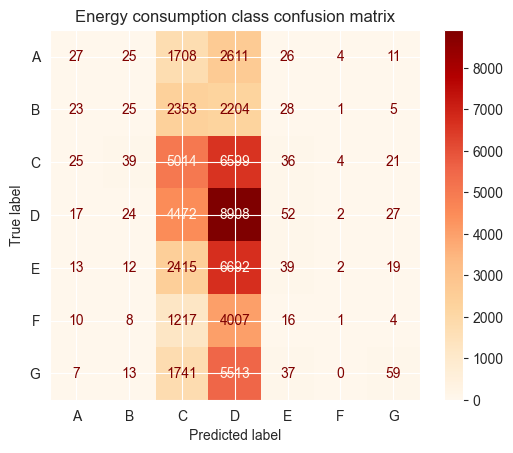

In [39]:
cm = confusion_matrix(
    y_true_energy_consumption,
    y_pred_energy_consumption,
    labels=energy_consumption_classes,
)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=energy_consumption_classes
)
disp.plot(cmap="OrRd")
plt.title("Energy consumption class confusion matrix")
plt.show()

In [40]:
f1_score(
    y_true=y_true_energy_consumption, y_pred=y_pred_energy_consumption, average="macro"
)

0.1042670335753112